# 🧠 BraTS 2020 Model Prediction 

## 🔧 Setup and Configuration

In [2]:
import os
import json
import torch
import numpy as np
import nibabel as nib
import onnxruntime as ort

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from tqdm import tqdm
from pathlib import Path
from matplotlib.patches import Patch
from plotly.subplots import make_subplots
from matplotlib.colors import ListedColormap

# MONAI imports
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Orientationd, Spacingd,
    NormalizeIntensityd, Activations, AsDiscrete, MapTransform, SpatialPadd
)
from monai.data import Dataset, DataLoader
from monai.networks.nets import SegResNet
from monai.inferers import sliding_window_inference

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

/home/student01/miniconda3/envs/brats-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
GPU: NVIDIA H100 80GB HBM3
GPU Memory: 79.18 GB


In [ ]:
# Configuration
CHECKPOINT_PATH = 'Outputs/SegResNet_brats_accelerate_20251009_060159/model_final_20251009_122935.onnx'
# CHECKPOINT_PATH = 'Outputs/SegResNet_brats_accelerate_20251009_060159/model_final_20251009_122935.pth'
DATA_DIR = 'Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
ROI_SIZE = (128, 128, 128)
NUM_CLASSES = 3
IN_CHANNELS = 4
SW_BATCH_SIZE = 2

CLASS_NAMES = ['Tumor Core (TC)', 'Whole Tumor (WT)', 'Enhancing Tumor (ET)']

class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """Convert single-channel labels to multi-channel based on BraTS 2020 regions"""
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # TC: label 1 or 4
            result.append(torch.logical_or(d[key] == 1, d[key] == 4))
            # WT: label 1 or 2 or 4
            result.append(torch.logical_or(torch.logical_or(d[key] == 1, d[key] == 4), d[key] == 2))
            # ET: label 4
            result.append(d[key] == 4)
            d[key] = torch.stack(result, axis=0).float()
        return d

def get_transforms(roi_size):
    """Get inference transforms"""
    return Compose([
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        SpatialPadd(keys=["image", "label"], spatial_size=roi_size, mode="constant"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ])

print("Transforms defined successfully!")

Transforms defined successfully!


## 🤖 Model Loading

In [ ]:
print(f"Loading model from: {CHECKPOINT_PATH}")

# Detect format and load accordingly
is_onnx = CHECKPOINT_PATH.lower().endswith('.onnx')
if not is_onnx:
    # Torch .pth loading (original)
    model = SegResNet(
        blocks_down=[1, 2, 2, 4],
        blocks_up=[1, 1, 1],
        init_filters=16,
        in_channels=IN_CHANNELS,
        out_channels=NUM_CLASSES,
        dropout_prob=0.2,
    )
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    print("✓ Torch model loaded successfully!")
    print(f"  Trained for {checkpoint['epoch']} epochs")
    print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    model_type = "Torch"
else:
    # ONNX loading
    session_options = ort.SessionOptions()
    if device.type == 'cuda':
        providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
    else:
        providers = ['CPUExecutionProvider']
    model = ort.InferenceSession(CHECKPOINT_PATH, sess_options=session_options, providers=providers)
    print("✓ ONNX model loaded successfully!")
    model_type = "ONNX"

print(f"  Model type: {model_type}")

Loading model from: Outputs/SegResNet_brats_accelerate_20251009_060159/model_final_20251009_122935.onnx
✓ ONNX model loaded successfully!
  Model type: ONNX


## 📂 Data Preparation

In [5]:
# Get list of available cases
cases = sorted([d for d in os.listdir(DATA_DIR)
                if os.path.isdir(os.path.join(DATA_DIR, d)) and d.startswith('BraTS20_Training_')])

print(f"Total cases available: {len(cases)}")
print(f"Sample cases: {cases[:5]}")

# Load actual test cases from training data split (15% test)
output_dir = Path("Outputs/SegResNet_brats_accelerate_20251009_060159")
data_split_path = output_dir / "data_split.json"
with open(data_split_path, 'r') as f:
    actual_split = json.load(f)

test_cases = actual_split['test']

train_count = len(actual_split['train'])
val_count = len(actual_split['val'])
test_count = len(actual_split['test'])
total_count = train_count + val_count + test_count

print(f"\nActual Data Split Used in Training (80/5/15):")
print(f"Total cases: {total_count}")
print(f"Training cases: {train_count} ({train_count/total_count*100:.1f}%)")
print(f"Validation cases: {val_count} ({val_count/total_count*100:.1f}%)")
print(f"Test cases: {test_count} ({test_count/total_count*100:.1f}%)")
print(f"\nLoaded {len(test_cases)} test cases for evaluation")
print(f"Test cases: {test_cases[:3]} ... {test_cases[-3:]}")

# Verify all test cases exist in the data directory
missing_cases = [case for case in test_cases if case not in cases]
if missing_cases:
    print(f"⚠️ Warning: {len(missing_cases)} test cases not found in data directory: {missing_cases[:3]}...")
else:
    print("✓ All test cases found in data directory")

# Prepare data list for test cases (4 modalities: flair, t1, t1ce, t2)
test_data_list = []
for case in test_cases:
    case_path = os.path.join(DATA_DIR, case)
    data_dict = {
        "image": [
            os.path.join(case_path, f"{case}_flair.nii"),
            os.path.join(case_path, f"{case}_t1.nii"),
            os.path.join(case_path, f"{case}_t1ce.nii"),
            os.path.join(case_path, f"{case}_t2.nii"),
        ],
        "label": os.path.join(case_path, f"{case}_seg.nii"),
        "case_id": case
    }
    test_data_list.append(data_dict)

print(f"Created data list with {len(test_data_list)} test cases")

# Create dataset and dataloader
transforms = get_transforms(ROI_SIZE)
test_dataset = Dataset(data=test_data_list, transform=transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

print(f"Test dataset ready with {len(test_dataset)} samples")

Total cases available: 369
Sample cases: ['BraTS20_Training_001', 'BraTS20_Training_002', 'BraTS20_Training_003', 'BraTS20_Training_004', 'BraTS20_Training_005']

Actual Data Split Used in Training (80/5/15):
Total cases: 369
Training cases: 295 (79.9%)
Validation cases: 18 (4.9%)
Test cases: 56 (15.2%)

Loaded 56 test cases for evaluation
Test cases: ['BraTS20_Training_296', 'BraTS20_Training_186', 'BraTS20_Training_151'] ... ['BraTS20_Training_013', 'BraTS20_Training_058', 'BraTS20_Training_328']
✓ All test cases found in data directory
Created data list with 56 test cases
Test dataset ready with 56 samples


/home/student01/miniconda3/envs/brats-env/lib/python3.12/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


## 🔍 Inference and Evaluation

In [ ]:
# Define post-processing
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# Metric calculation functions
def calculate_dice_score(pred, target, epsilon=1e-8):
    """Calculate Dice score for each class"""
    dice_scores = []
    for c in range(pred.shape[0]):
        pred_c = pred[c].flatten()
        target_c = target[c].flatten()
        intersection = (pred_c * target_c).sum()
        dice = (2.0 * intersection + epsilon) / (pred_c.sum() + target_c.sum() + epsilon)
        dice_scores.append(dice.item())
    return dice_scores

def calculate_precision_recall(pred, target, epsilon=1e-8):
    """Calculate Precision and Recall for each class"""
    precisions = []
    recalls = []
    for c in range(pred.shape[0]):
        pred_c = pred[c].flatten()
        target_c = target[c].flatten()
        tp = (pred_c * target_c).sum()
        fp = (pred_c * (1 - target_c)).sum()
        fn = ((1 - pred_c) * target_c).sum()
        
        precision = (tp + epsilon) / (tp + fp + epsilon)
        recall = (tp + epsilon) / (tp + fn + epsilon)
        
        precisions.append(precision.item())
        recalls.append(recall.item())
    return precisions, recalls

print("Metric functions defined!")

# Run inference on all test cases
print("Running inference on test set...")

all_dice_scores = []
all_precisions = []
all_recalls = []
predictions = []

with torch.no_grad():
    for batch_data in tqdm(test_loader, desc="Processing test cases"):
        images = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)
        
        if not is_onnx:
            # Torch inference with sliding window
            outputs = sliding_window_inference(
                inputs=images,
                roi_size=ROI_SIZE,
                sw_batch_size=SW_BATCH_SIZE,
                predictor=model,
                overlap=0.5
            )
        else:
            images_np = images.cpu().numpy()
            ort_inputs = {model.get_inputs()[0].name: images_np}
            outputs_np = model.run(None, ort_inputs)[0]
            outputs = torch.from_numpy(outputs_np).to(device)
        
        if is_onnx:
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > 0.5).float()
        else:
            outputs = post_trans(outputs)
        
        # Calculate metrics
        dice_scores = calculate_dice_score(outputs[0], labels[0])
        precisions, recalls = calculate_precision_recall(outputs[0], labels[0])
        
        all_dice_scores.append(dice_scores)
        all_precisions.append(precisions)
        all_recalls.append(recalls)
        
        predictions.append({
            'case_id': batch_data['case_id'][0],
            'image': images[0].cpu().numpy(),
            'pred': outputs[0].cpu().numpy(),
            'label': labels[0].cpu().numpy(),
            'dice': dice_scores,
            'precision': precisions,
            'recall': recalls
        })

print(f"\n✓ Inference complete! Processed {len(predictions)} cases")

Metric functions defined!
Running inference on test set...


Processing test cases: 100%|██████████| 56/56 [00:13<00:00,  4.11it/s]


✓ Inference complete! Processed 56 cases


## 📈 Performance Analysis

In [8]:
# Calculate average metrics across all test cases
avg_dice = np.mean(all_dice_scores, axis=0)
avg_precision = np.mean(all_precisions, axis=0)
avg_recall = np.mean(all_recalls, axis=0)

# Display metrics table
print("="*80)
print(f"{'TEST SET METRICS':^80}")
print("="*80)
print(f"{'Class':<30} ║ {'Dice':<12} ║ {'Precision':<12} ║ {'Recall':<12}")
print("="*80)

for i, class_name in enumerate(CLASS_NAMES):
    print(f"{class_name:<30} ║ {avg_dice[i]:<12.4f} ║ {avg_precision[i]:<12.4f} ║ {avg_recall[i]:<12.4f}")

print("-"*80)
print(f"{'AVERAGE':<30} ║ {np.mean(avg_dice):<12.4f} ║ {np.mean(avg_precision):<12.4f} ║ {np.mean(avg_recall):<12.4f}")
print("="*80)

# Display standard deviations
std_dice = np.std(all_dice_scores, axis=0)
std_precision = np.std(all_precisions, axis=0)
std_recall = np.std(all_recalls, axis=0)

print(f"\n{'STANDARD DEVIATIONS':^80}")
print("="*80)
for i, class_name in enumerate(CLASS_NAMES):
    print(f"{class_name:<30} ║ {std_dice[i]:<12.4f} ║ {std_precision[i]:<12.4f} ║ {std_recall[i]:<12.4f}")
print("="*80)

                                TEST SET METRICS                                
Class                          ║ Dice         ║ Precision    ║ Recall      
Tumor Core (TC)                ║ 0.7986       ║ 0.8322       ║ 0.8212      
Whole Tumor (WT)               ║ 0.8921       ║ 0.9090       ║ 0.8870      
Enhancing Tumor (ET)           ║ 0.7164       ║ 0.7047       ║ 0.8154      
--------------------------------------------------------------------------------
AVERAGE                        ║ 0.8024       ║ 0.8153       ║ 0.8412      

                              STANDARD DEVIATIONS                               
Tumor Core (TC)                ║ 0.2185       ║ 0.2410       ║ 0.1828      
Whole Tumor (WT)               ║ 0.0767       ║ 0.0615       ║ 0.1129      
Enhancing Tumor (ET)           ║ 0.2099       ║ 0.2419       ║ 0.1536      


## 📊 Results Visualization

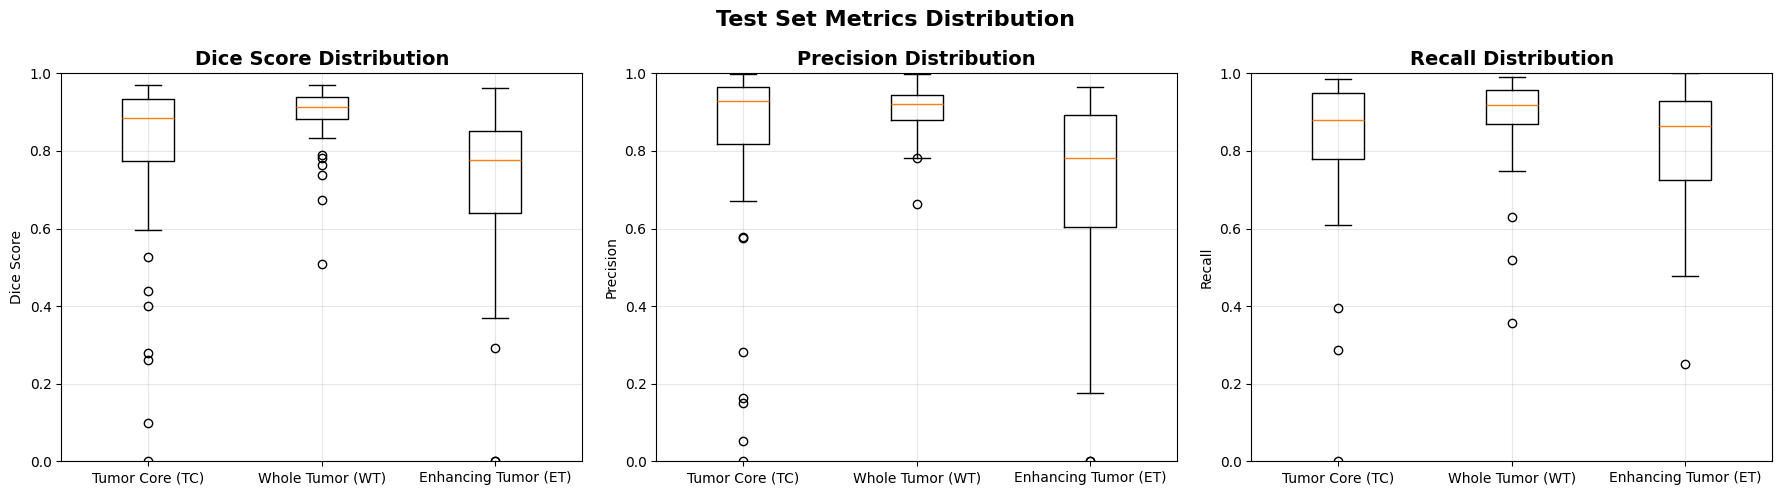

In [9]:
# Plot metrics distribution (boxplots)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Dice scores
dice_array = np.array(all_dice_scores)
axes[0].boxplot([dice_array[:, i] for i in range(NUM_CLASSES)], tick_labels=CLASS_NAMES)
axes[0].set_title('Dice Score Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Dice Score')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Precision
precision_array = np.array(all_precisions)
axes[1].boxplot([precision_array[:, i] for i in range(NUM_CLASSES)], tick_labels=CLASS_NAMES)
axes[1].set_title('Precision Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Precision')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

# Recall
recall_array = np.array(all_recalls)
axes[2].boxplot([recall_array[:, i] for i in range(NUM_CLASSES)], tick_labels=CLASS_NAMES)
axes[2].set_title('Recall Distribution', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Recall')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([0, 1])

# Add main title
fig.suptitle('Test Set Metrics Distribution', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

## 🖼️ Prediction Visualizations

In [ ]:
def visualize_prediction(pred_data, slice_idx=None):
    """Visualize prediction vs ground truth in EDA style (fixed for BraTS multi-label)."""
    case_id = pred_data['case_id']
    image = pred_data['image']  
    pred = pred_data['pred']   
    label = pred_data['label'] 
    dice = pred_data['dice']
    precision = pred_data['precision']
    recall = pred_data['recall']
    
    # Auto-select axial slice (depth) with most tumor volume
    if slice_idx is None:
        tumor_per_slice = label.sum(axis=(0, 1, 2))
        slice_idx = int(np.argmax(tumor_per_slice))
        if tumor_per_slice[slice_idx] == 0:
            print(f"Warning: No tumor in {case_id}; showing middle slice {slice_idx}.")
            slice_idx = label.shape[3] // 2  # Fallback
    
    # Get axial slices
    flair = image[0, :, :, slice_idx]
    t1 = image[1, :, :, slice_idx]
    t1ce = image[2, :, :, slice_idx]
    t2 = image[3, :, :, slice_idx]
    
    # Correct multi-to-single (priority: ET > TC > WT)
    def multi_to_single(multi_slice):
        single = np.zeros_like(multi_slice[0])  
        et_mask = multi_slice[2] > 0.5
        tc_mask = (multi_slice[0] > 0.5) & (~et_mask)
        wt_mask = (multi_slice[1] > 0.5) & (np.logical_not(multi_slice[0] > 0.5)) 
        single[et_mask] = 4  # ET (blue)
        single[tc_mask] = 1  # TC only (red)
        single[wt_mask] = 2  # WT only (green)
        return single
    
    label_slice = multi_to_single(label[:, :, :, slice_idx])
    pred_slice = multi_to_single(pred[:, :, :, slice_idx])
    
    # Figure: 2x4 (modalities + segs/overlay)
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    
    # Title
    title = f"{case_id} - Axial Slice {slice_idx} (Tumor Vol: {label.sum(axis=(0,1,2))[slice_idx]:.0f} vox)\n"
    title += f"Dice: TC={dice[0]:.3f}, WT={dice[1]:.3f}, ET={dice[2]:.3f} | Avg={np.mean(dice):.3f}"
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    # Row 1: Modalities
    axes[0, 0].imshow(flair.T, cmap='gray', origin='lower')
    axes[0, 0].set_title('FLAIR', fontsize=12); axes[0, 0].axis('off')
    
    axes[0, 1].imshow(t1.T, cmap='gray', origin='lower')
    axes[0, 1].set_title('T1', fontsize=12); axes[0, 1].axis('off')
    
    axes[0, 2].imshow(t1ce.T, cmap='gray', origin='lower')
    axes[0, 2].set_title('T1CE', fontsize=12); axes[0, 2].axis('off')
    
    axes[0, 3].imshow(t2.T, cmap='gray', origin='lower')
    axes[0, 3].set_title('T2', fontsize=12); axes[0, 3].axis('off')
    
    # Row 2: GT, Pred, Overlay
    colors = ['black', 'red', 'green', 'white', 'blue']
    cmap = ListedColormap(colors)
    
    axes[1, 0].imshow(label_slice.T, cmap=cmap, origin='lower', vmin=0, vmax=4)
    axes[1, 0].set_title('Ground Truth', fontsize=12, fontweight='bold'); axes[1, 0].axis('off')
    
    axes[1, 1].imshow(pred_slice.T, cmap=cmap, origin='lower', vmin=0, vmax=4)
    axes[1, 1].set_title('Prediction', fontsize=12, fontweight='bold'); axes[1, 1].axis('off')
    
    # Overlay on T1CE
    axes[1, 2].imshow(t1ce.T, cmap='gray', origin='lower', alpha=0.7)
    match_mask = (label_slice == pred_slice) & (label_slice > 0)
    error_mask = (label_slice != pred_slice) & ((label_slice > 0) | (pred_slice > 0))
    axes[1, 2].imshow(match_mask.T.astype(float), cmap='Greens', alpha=0.6, origin='lower')
    axes[1, 2].imshow(error_mask.T.astype(float), cmap='Reds', alpha=0.6, origin='lower')
    axes[1, 2].set_title('Overlay (Green=Match, Red=Error)', fontsize=12, fontweight='bold'); axes[1, 2].axis('off')
    
    axes[1, 3].axis('off')  # Empty
    
    # Legend
    legend_elements = [
        Patch(facecolor='black', label='0: Background'),
        Patch(facecolor='red', label='1: NCR/NET (TC)'),
        Patch(facecolor='green', label='2: ED (WT)'),
        Patch(facecolor='blue', label='4: ET')
    ]
    fig.legend(handles=legend_elements, loc='lower center', fontsize='medium', ncol=4, bbox_to_anchor=(0.5, -0.02))
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print("\nDetailed Metrics:")
    print("-" * 60)
    for i, class_name in enumerate(CLASS_NAMES):
        print(f"{class_name:20s}: Dice={dice[i]:.4f}, Prec={precision[i]:.4f}, Rec={recall[i]:.4f}")
    print("-" * 60)

print("Fixed visualization function ready (boolean inversion bug resolved)!")

Fixed visualization function ready (boolean inversion bug resolved)!


## 🏆 Example Predictions

Visualizing 3 example predictions...


Example 1/3


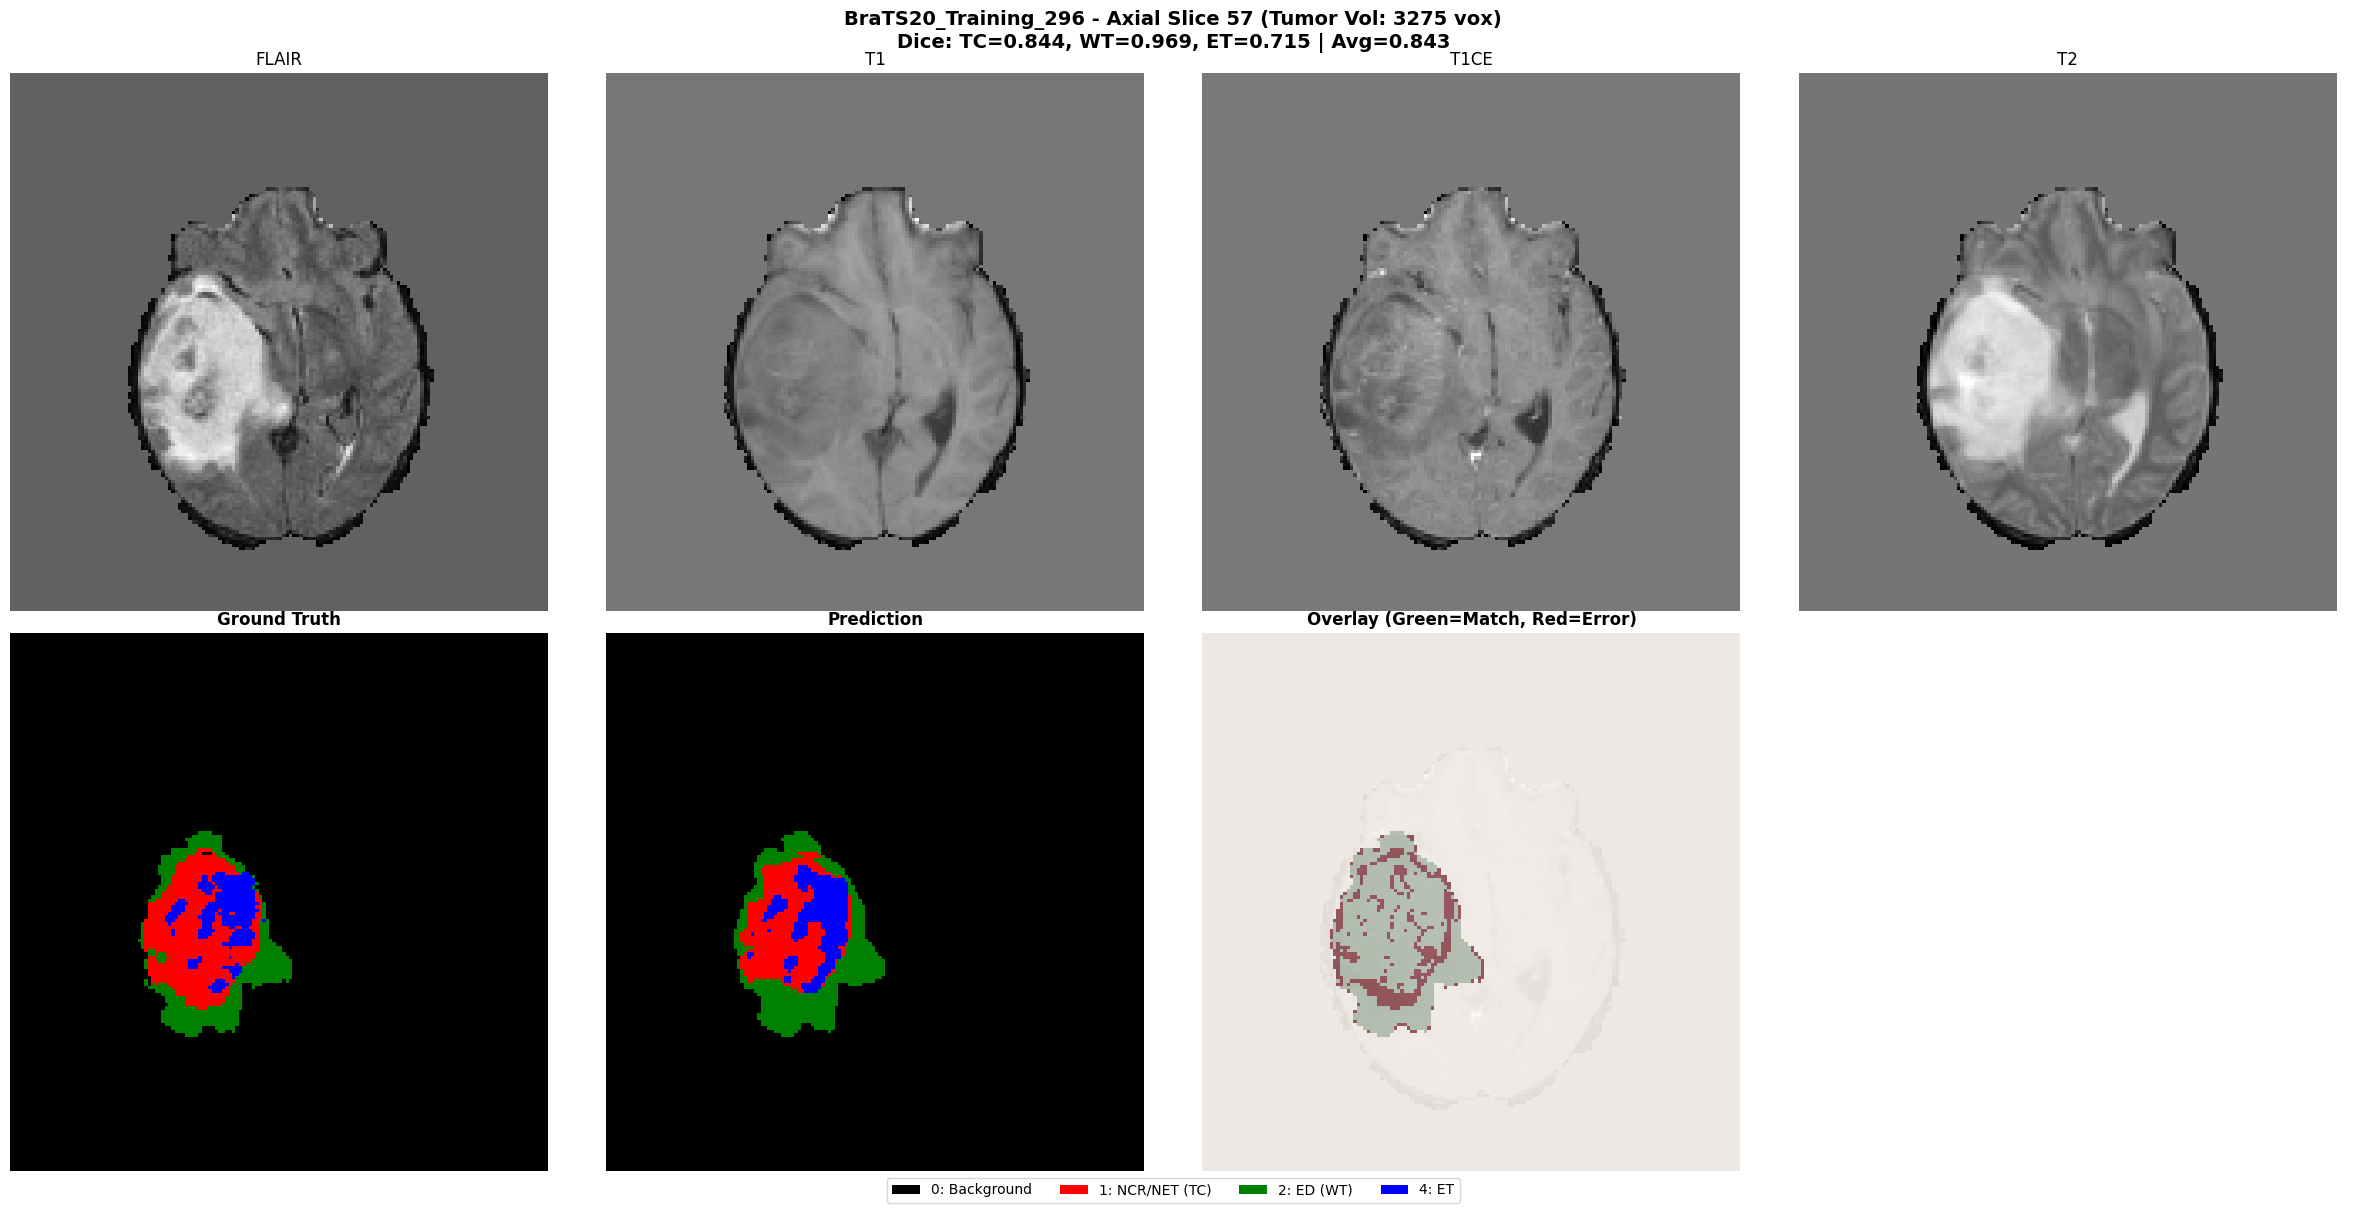


Detailed Metrics:
------------------------------------------------------------
Tumor Core (TC)     : Dice=0.8443, Prec=0.9094, Rec=0.7879
Whole Tumor (WT)    : Dice=0.9687, Prec=0.9600, Rec=0.9777
Enhancing Tumor (ET): Dice=0.7145, Prec=0.7109, Rec=0.7183
------------------------------------------------------------

Example 2/3


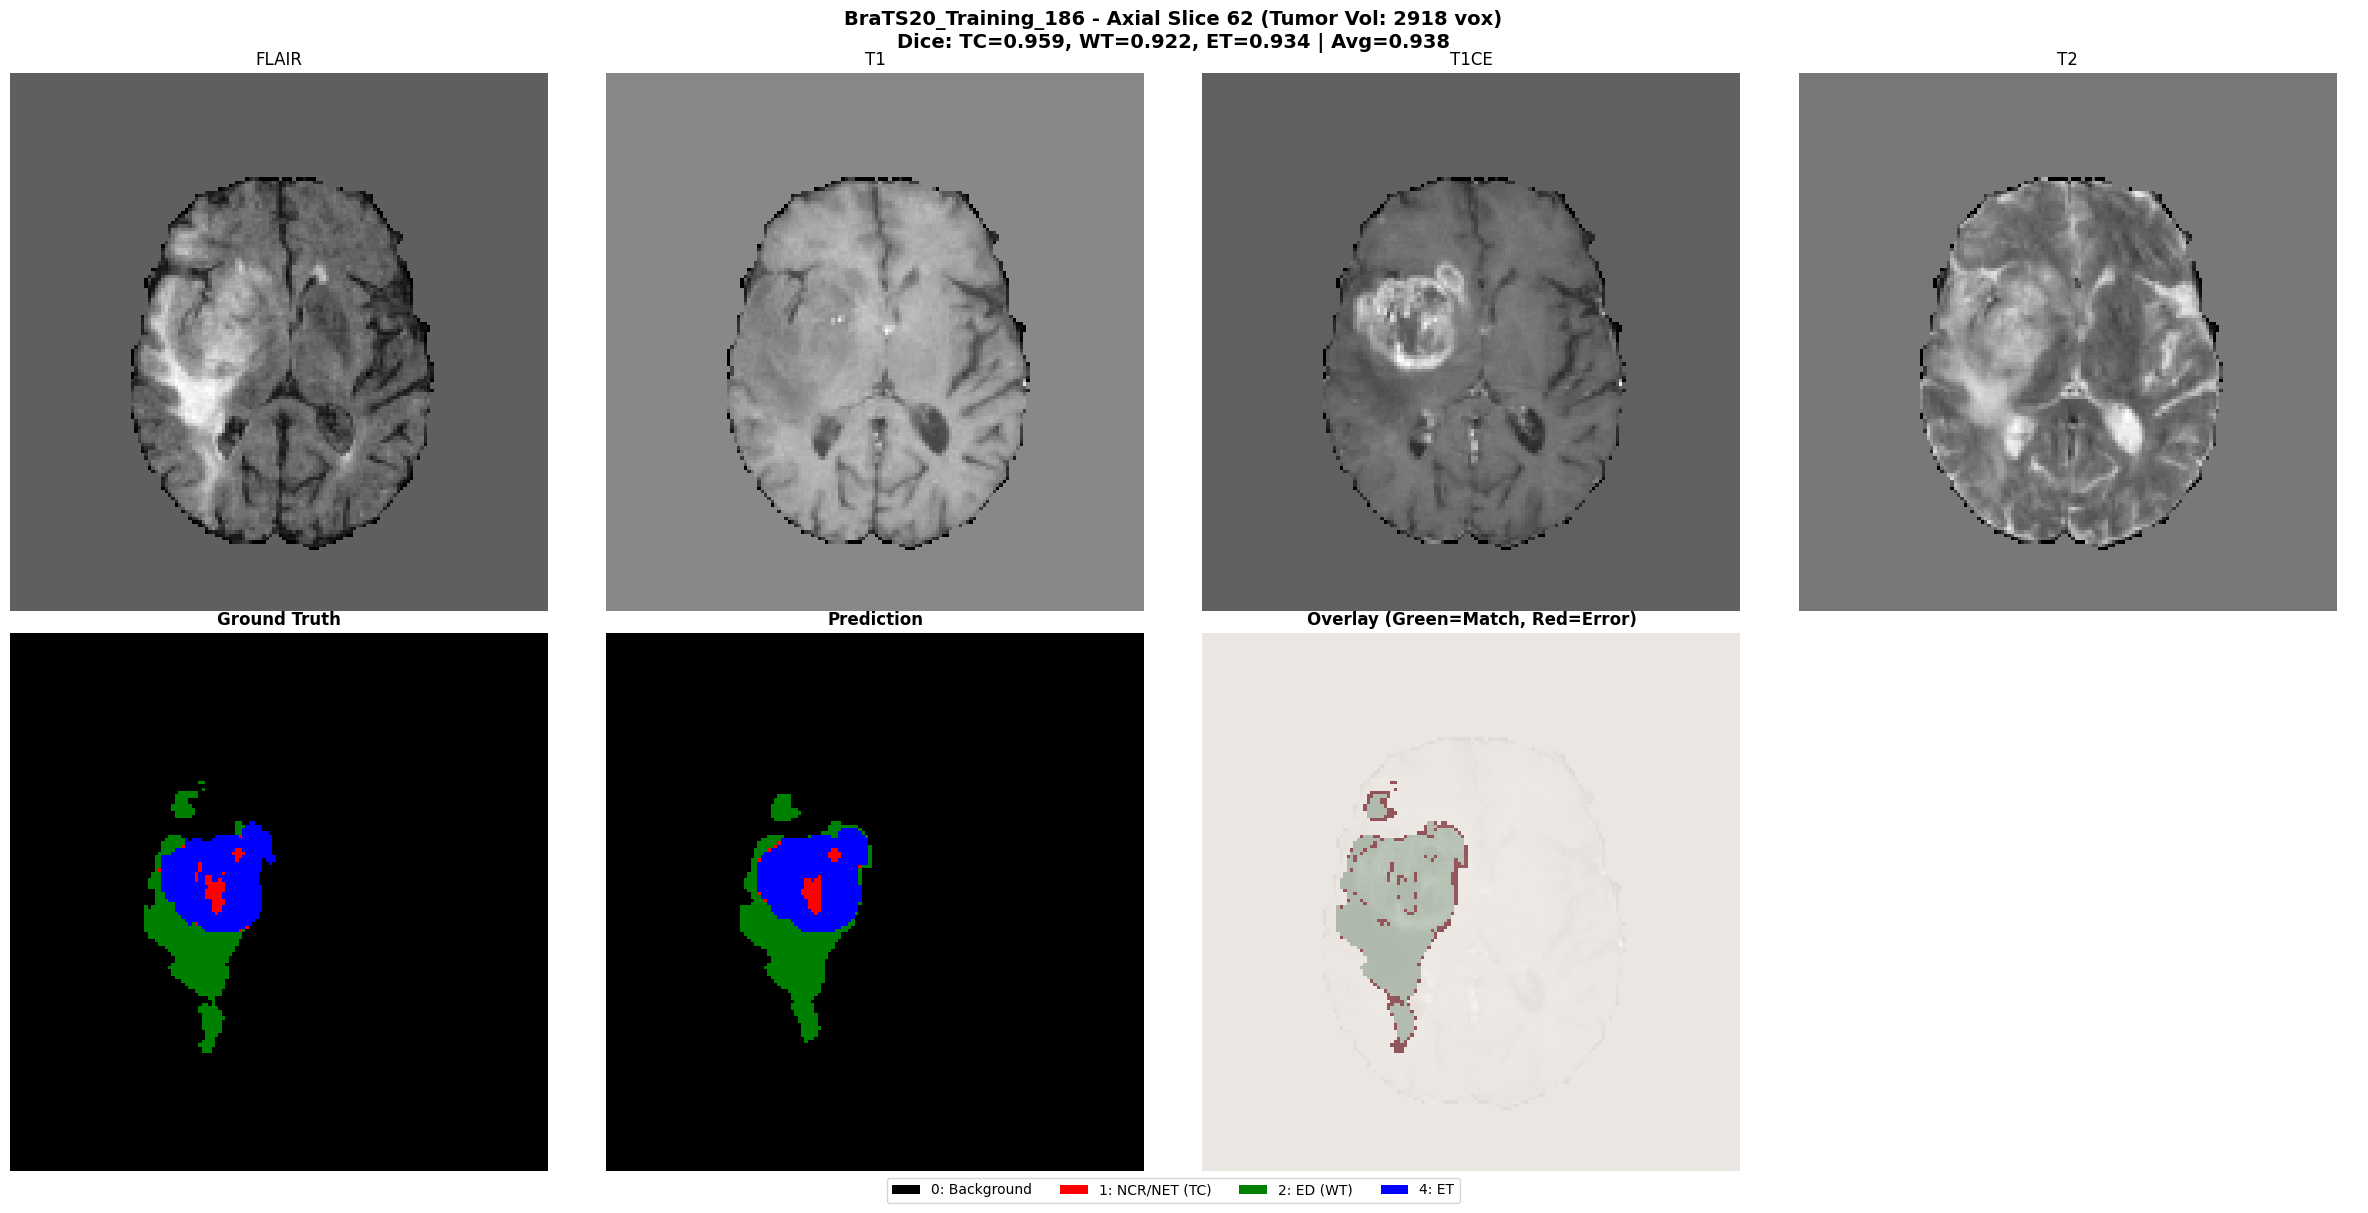


Detailed Metrics:
------------------------------------------------------------
Tumor Core (TC)     : Dice=0.9595, Prec=0.9489, Rec=0.9703
Whole Tumor (WT)    : Dice=0.9221, Prec=0.8746, Rec=0.9751
Enhancing Tumor (ET): Dice=0.9338, Prec=0.9135, Rec=0.9551
------------------------------------------------------------

Example 3/3


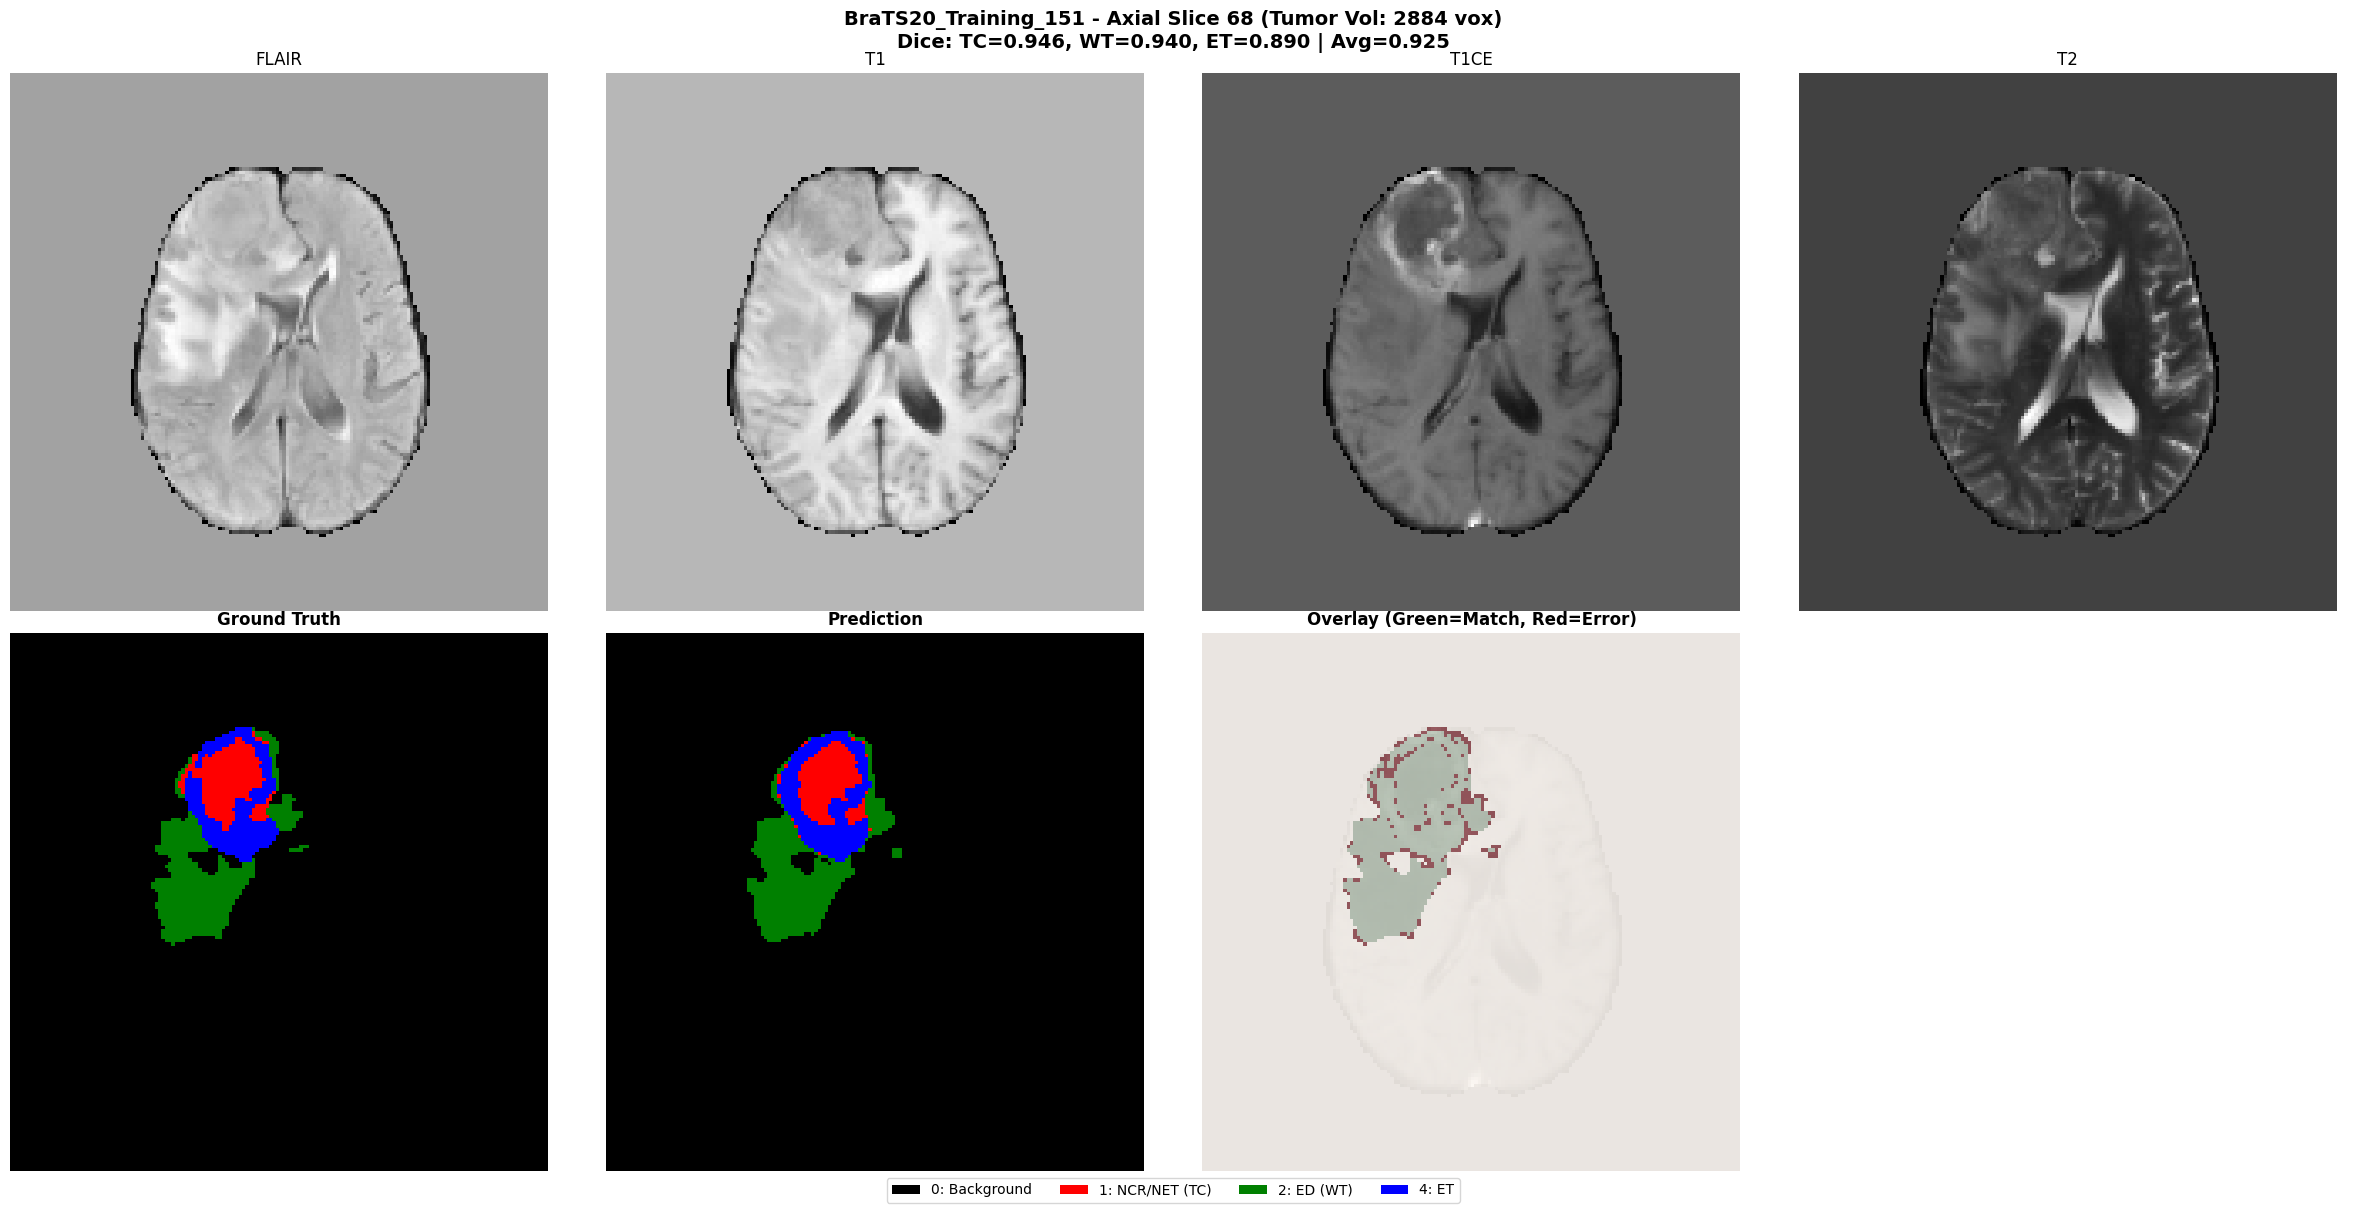


Detailed Metrics:
------------------------------------------------------------
Tumor Core (TC)     : Dice=0.9460, Prec=0.9378, Rec=0.9544
Whole Tumor (WT)    : Dice=0.9396, Prec=0.9262, Rec=0.9534
Enhancing Tumor (ET): Dice=0.8903, Prec=0.8754, Rec=0.9057
------------------------------------------------------------


In [11]:
# Visualize first 3 examples (in one cell)
NUM_EXAMPLES = min(3, len(predictions))
print(f"Visualizing {NUM_EXAMPLES} example predictions...\n")
for i in range(NUM_EXAMPLES):
    print(f"\n{'='*80}")
    print(f"Example {i+1}/{NUM_EXAMPLES}")
    print(f"{'='*80}")
    visualize_prediction(predictions[i])

## 🏆 Best and Worst Predictions

Best case: BraTS20_Training_230 (Avg Dice: 0.9566)
Worst case: BraTS20_Training_275 (Avg Dice: 0.1694)

BEST PREDICTION


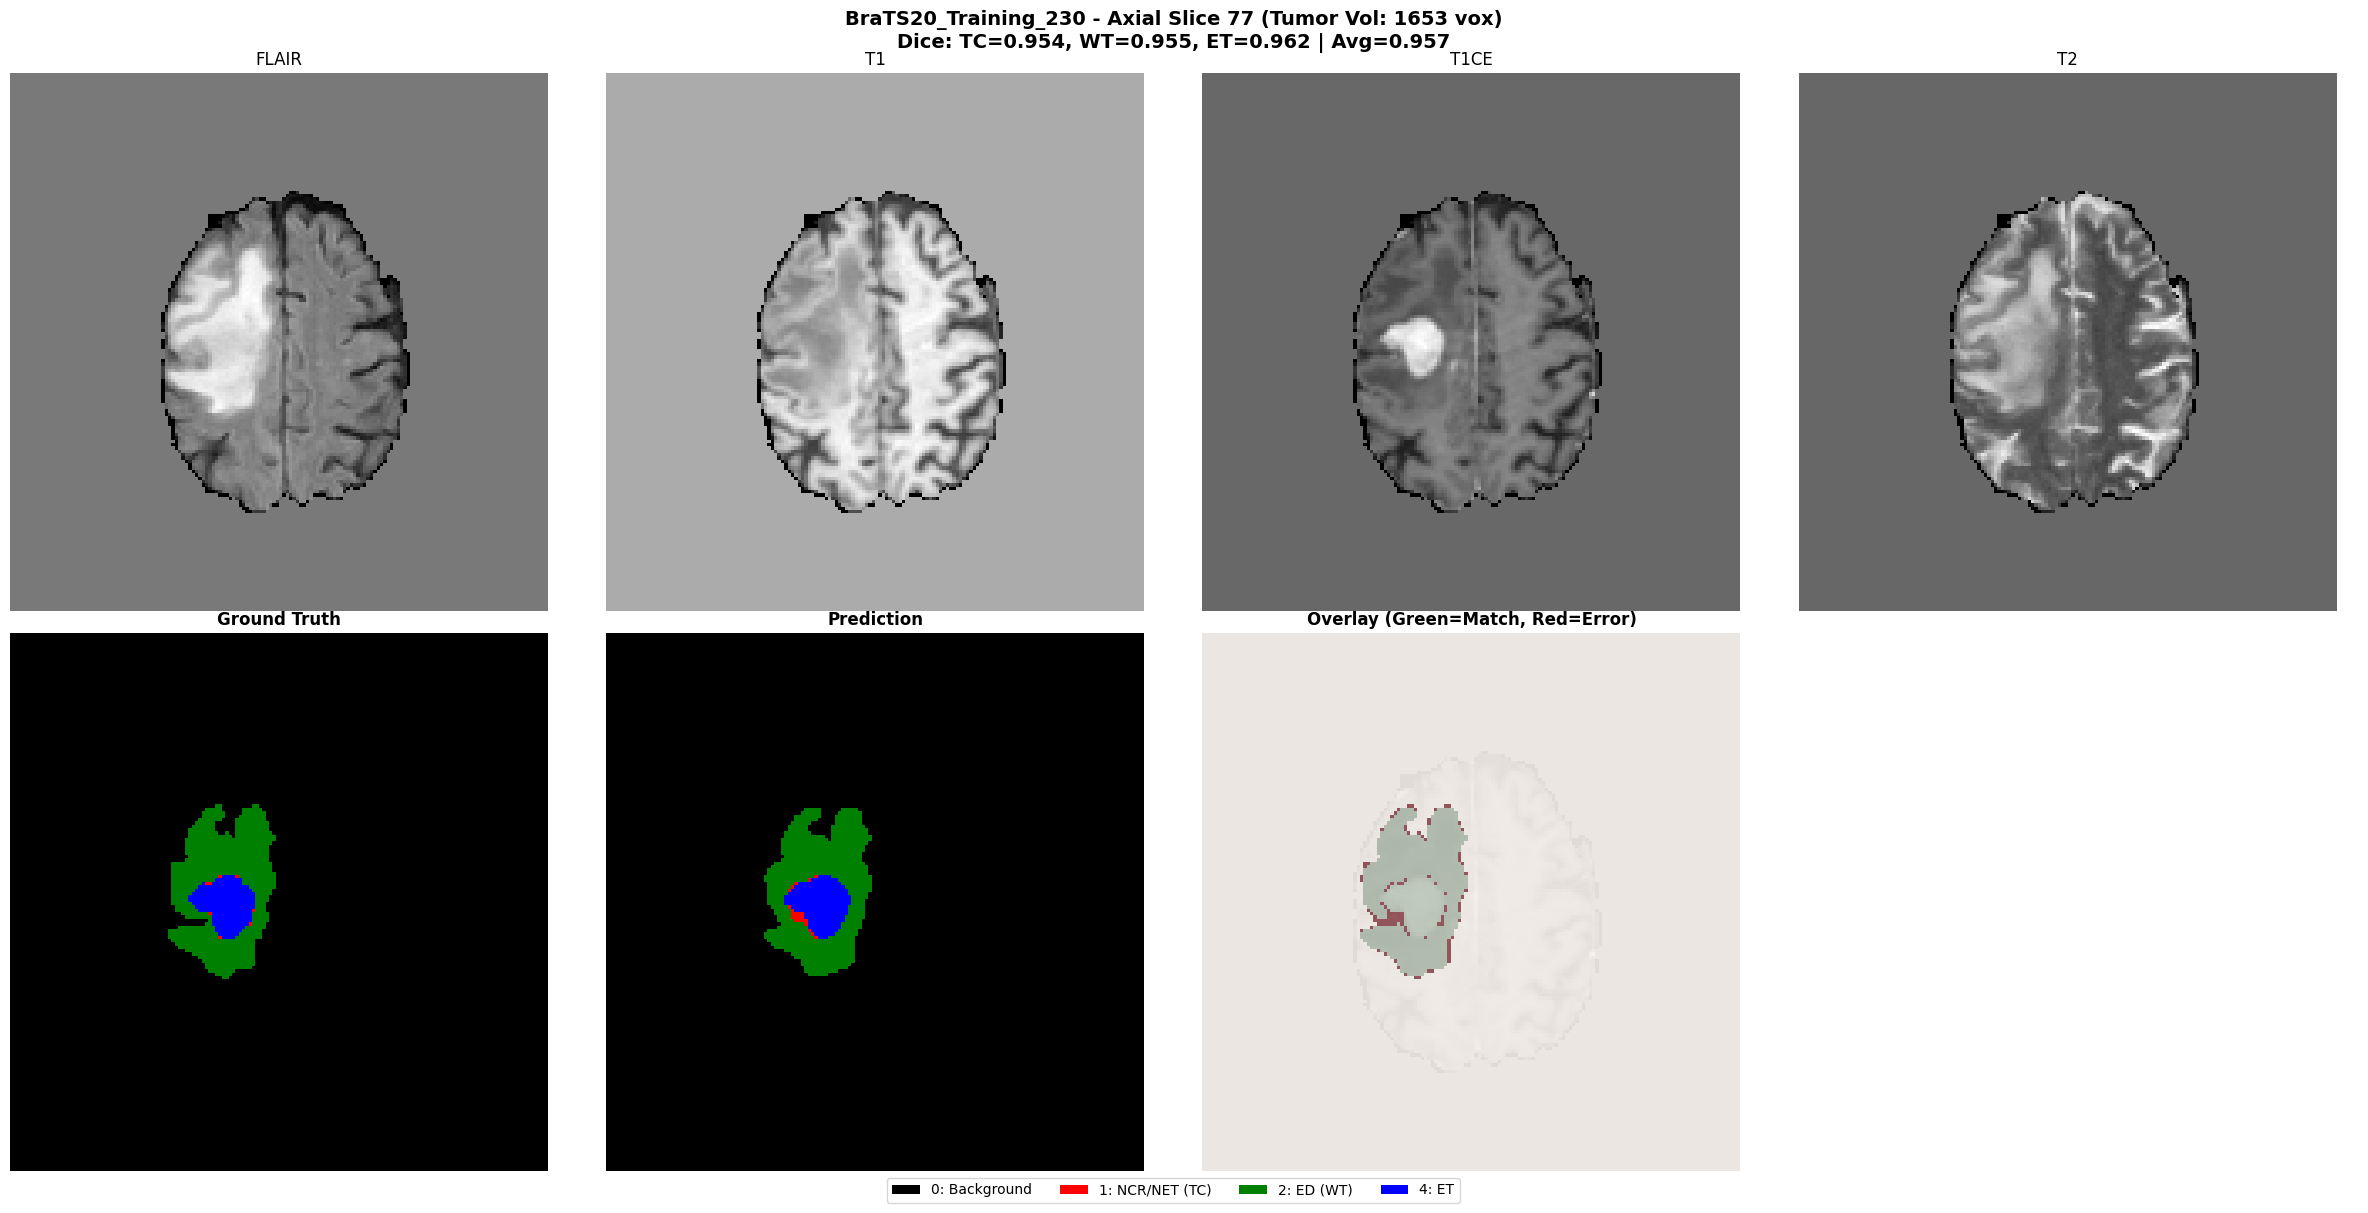


Detailed Metrics:
------------------------------------------------------------
Tumor Core (TC)     : Dice=0.9536, Prec=0.9344, Rec=0.9736
Whole Tumor (WT)    : Dice=0.9545, Prec=0.9398, Rec=0.9697
Enhancing Tumor (ET): Dice=0.9617, Prec=0.9468, Rec=0.9771
------------------------------------------------------------

WORST PREDICTION


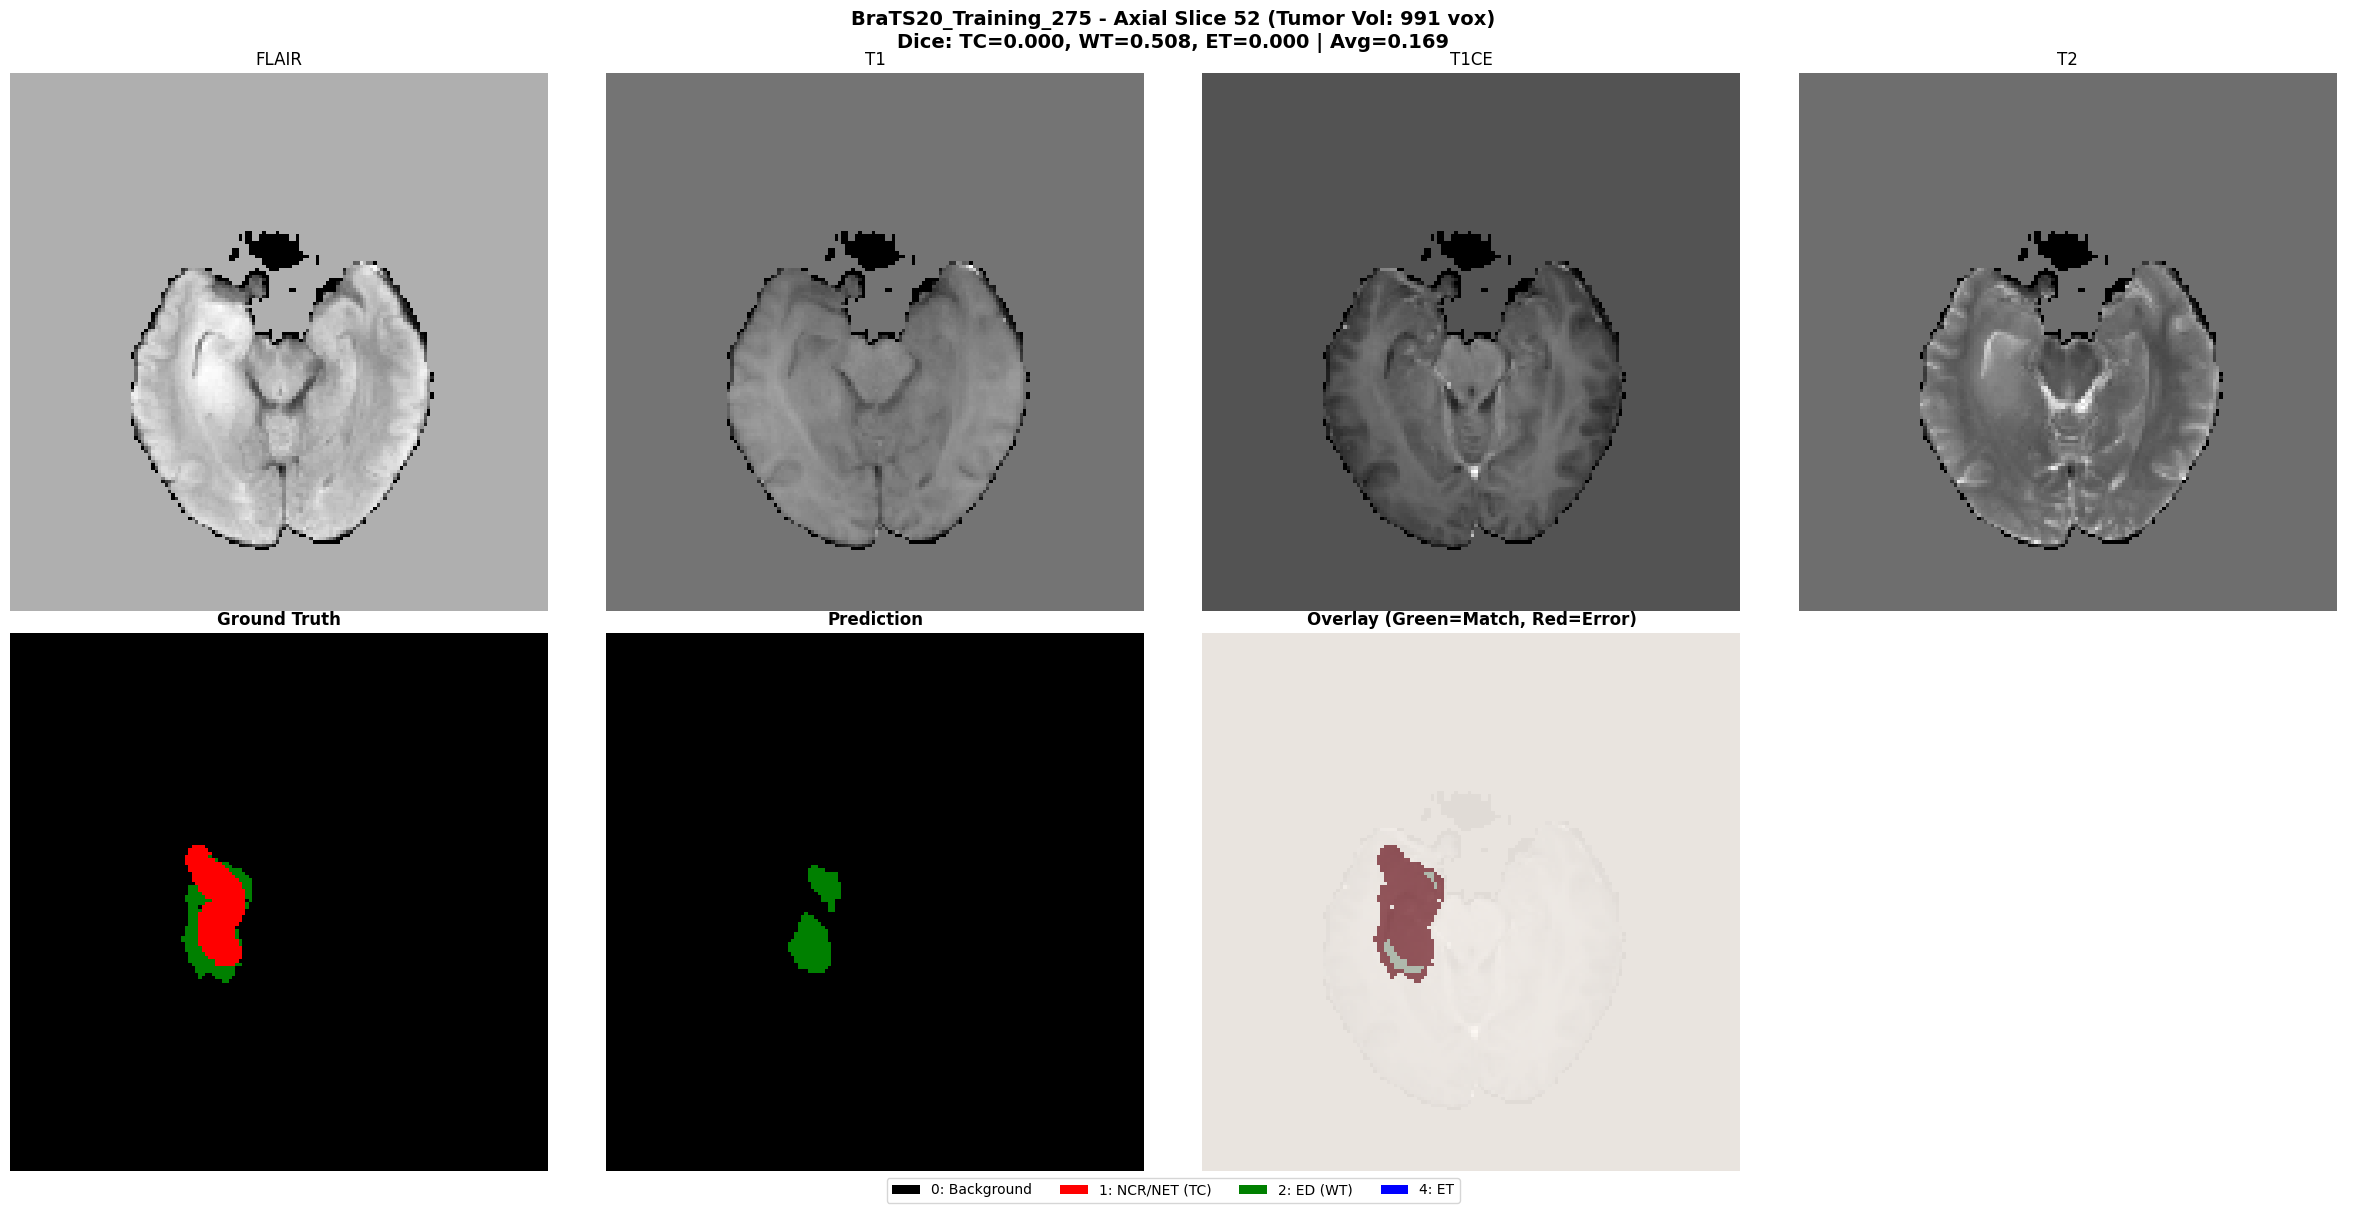


Detailed Metrics:
------------------------------------------------------------
Tumor Core (TC)     : Dice=0.0000, Prec=0.0000, Rec=0.0000
Whole Tumor (WT)    : Dice=0.5081, Prec=0.8834, Rec=0.3566
Enhancing Tumor (ET): Dice=0.0000, Prec=0.0000, Rec=1.0000
------------------------------------------------------------


In [12]:
# Find best and worst (recompute here for clarity)
avg_dice_per_case = [np.mean(p['dice']) for p in predictions]
best_idx = np.argmax(avg_dice_per_case)
worst_idx = np.argmin(avg_dice_per_case)

print(f"Best case: {predictions[best_idx]['case_id']} (Avg Dice: {avg_dice_per_case[best_idx]:.4f})")
print(f"Worst case: {predictions[worst_idx]['case_id']} (Avg Dice: {avg_dice_per_case[worst_idx]:.4f})")

# Visualize BEST (now fixed: should show tumor if present)
print(f"\n{'='*80}")
print(f"BEST PREDICTION")
print(f"{'='*80}")
visualize_prediction(predictions[best_idx])

# Visualize WORST (now shows errors in red)
print(f"\n{'='*80}")
print(f"WORST PREDICTION")
print(f"{'='*80}")
visualize_prediction(predictions[worst_idx])

## 🔬 3D Analysis

In [ ]:
def visualize_3d_comparison(pred_data, downsample_factor=4, max_brain_points=15000, max_tumor_points=3000):
    """Create side-by-side 3D visualization: Ground Truth (left) vs Prediction (right)"""
    
    case_id = pred_data['case_id']
    pred = pred_data['pred']
    label = pred_data['label']
    
    case_path = os.path.join(DATA_DIR, case_id)
    t1ce_file = os.path.join(case_path, f"{case_id}_t1ce.nii")
    t1ce_img = nib.load(t1ce_file)
    t1ce_data = t1ce_img.get_fdata()
    
    brain = t1ce_data[::downsample_factor, ::downsample_factor, ::downsample_factor]

    pred_down = pred[:, ::downsample_factor, ::downsample_factor, ::downsample_factor]
    label_down = label[:, ::downsample_factor, ::downsample_factor, ::downsample_factor]
    
    brain_norm = (brain - brain.min()) / (brain.max() - brain.min())
    
    # Ground Truth: TC=1, WT=2, ET=4
    gt_seg = np.zeros_like(label_down[0])
    gt_seg[label_down[1] > 0.5] = 2  # WT (Whole Tumor) - green
    gt_seg[label_down[0] > 0.5] = 1  # TC (Tumor Core) - red
    gt_seg[label_down[2] > 0.5] = 4  # ET (Enhancing Tumor) - blue
    
    # Prediction
    pred_seg = np.zeros_like(pred_down[0])
    pred_seg[pred_down[1] > 0.5] = 2  # WT
    pred_seg[pred_down[0] > 0.5] = 1  # TC
    pred_seg[pred_down[2] > 0.5] = 4  # ET
    
    # Create subplots: 1 row, 2 columns for 3D scenes
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
        subplot_titles=('<b>Ground Truth</b>', '<b>Prediction</b>'),
        horizontal_spacing=0.02
    )
    
    # Prepare brain tissue coordinates
    brain_mask = brain_norm > 0.2
    coords = np.where(brain_mask)
    
    if len(coords[0]) > 0:
  
        brain_sample_idx = np.random.choice(len(coords[0]), 
                                           min(max_brain_points, len(coords[0])), 
                                           replace=False)
        
        # === LEFT SUBPLOT: GROUND TRUTH ===
        fig.add_trace(
            go.Scatter3d(
                x=coords[0][brain_sample_idx],
                y=coords[1][brain_sample_idx],
                z=coords[2][brain_sample_idx],
                mode='markers',
                marker=dict(size=2, color='lightgray', opacity=0.4),
                name='Brain Tissue',
                legendgroup='brain',
                showlegend=True
            ),
            row=1, col=1
        )
        
        # Add ground truth tumor classes 
        gt_tumor_classes = {
            1: ("NCR/NET", "red", 0.3),    
            2: ("ED", "green", 0.05),         
            4: ("ET", "blue", 0.1)   
        }
        
        for lbl, (label_name, color, opacity) in gt_tumor_classes.items():
            tumor_coords = np.where(gt_seg == lbl)
            if tumor_coords[0].size > 0:
                sample_idx = np.random.choice(len(tumor_coords[0]), 
                                             min(max_tumor_points, len(tumor_coords[0])), 
                                             replace=False)
                fig.add_trace(
                    go.Scatter3d(
                        x=tumor_coords[0][sample_idx],
                        y=tumor_coords[1][sample_idx],
                        z=tumor_coords[2][sample_idx],
                        mode='markers',
                        marker=dict(size=4, color=color, opacity=opacity),
                        name=label_name,
                        legendgroup=f'gt_{lbl}',
                        showlegend=True
                    ),
                    row=1, col=1
                )
        
        # === RIGHT SUBPLOT: PREDICTION ===
        fig.add_trace(
            go.Scatter3d(
                x=coords[0][brain_sample_idx],
                y=coords[1][brain_sample_idx],
                z=coords[2][brain_sample_idx],
                mode='markers',
                marker=dict(size=2, color='lightgray', opacity=0.4),
                name='Brain Tissue',
                legendgroup='brain2',
                showlegend=False
            ),
            row=1, col=2
        )
        
        # Add prediction tumor classes
        pred_tumor_classes = {
            1: ("NCR/NET (Pred)", "red", 0.3),
            2: ("ED (Pred)", "green", 0.05),
            4: ("ET (Pred)", "blue", 0.1)
        }
        
        for lbl, (label_name, color, opacity) in pred_tumor_classes.items():
            tumor_coords = np.where(pred_seg == lbl)
            if tumor_coords[0].size > 0:
                sample_idx = np.random.choice(len(tumor_coords[0]), 
                                             min(max_tumor_points, len(tumor_coords[0])), 
                                             replace=False)
                fig.add_trace(
                    go.Scatter3d(
                        x=tumor_coords[0][sample_idx],
                        y=tumor_coords[1][sample_idx],
                        z=tumor_coords[2][sample_idx],
                        mode='markers',
                        marker=dict(size=4, color=color, opacity=opacity),
                        name=label_name,
                        legendgroup=f'pred_{lbl}',
                        showlegend=True
                    ),
                    row=1, col=2
                )
    
    # Update layout
    fig.update_layout(
        title=dict(
            text=(f'<b>3D Brain Tumor Segmentation Comparison: {case_id}</b><br>'
                  f'<span style="font-size:12px">Dice Scores - '
                  f'TC: {pred_data["dice"][0]:.3f} | '
                  f'WT: {pred_data["dice"][1]:.3f} | '
                  f'ET: {pred_data["dice"][2]:.3f} | '
                  f'<b>Average: {np.mean(pred_data["dice"]):.3f}</b></span>'),
            x=0.5,
            xanchor='center',
            font=dict(size=14)
        ),
        height=700,
        width=1400,
        margin=dict(l=0, r=0, b=80, t=120),
        legend=dict(
            x=0.5,
            y=-0.08,
            xanchor='center',
            yanchor='top',
            orientation='h',
            bgcolor='rgba(255,255,255,0.6)',
            bordercolor='black',
            borderwidth=1,
            itemsizing='constant',
            font=dict(size=12)
        )
    )
    
    # Update 3D scene properties
    scene_props = dict(
        xaxis_title='Sagittal',
        yaxis_title='Coronal',
        zaxis_title='Axial',
        aspectmode='data',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5)),
        xaxis=dict(showbackground=True, backgroundcolor="rgb(230, 230,230)"),
        yaxis=dict(showbackground=True, backgroundcolor="rgb(230, 230,230)"),
        zaxis=dict(showbackground=True, backgroundcolor="rgb(230, 230,230)")
    )
    
    fig.update_scenes(scene_props)
    
    fig.show()

print("✓ Side-by-side 3D comparison function ready (using ORIGINAL T1CE data like EDA)!")

✓ Side-by-side 3D comparison function ready (using ORIGINAL T1CE data like EDA)!


In [ ]:
# 3D for best
print(f"Creating side-by-side 3D comparison for BEST case: {predictions[best_idx]['case_id']}")
print(f"Average Dice Score: {avg_dice_per_case[best_idx]:.4f}")
print("="*80)
visualize_3d_comparison(predictions[best_idx])

Creating side-by-side 3D comparison for BEST case: BraTS20_Training_230
Average Dice Score: 0.9566


In [ ]:
# 3D for worst
print(f"\nCreating side-by-side 3D comparison for WORST case: {predictions[worst_idx]['case_id']}")
print(f"Average Dice Score: {avg_dice_per_case[worst_idx]:.4f}")
print("="*80)
visualize_3d_comparison(predictions[worst_idx])


Creating side-by-side 3D comparison for WORST case: BraTS20_Training_275
Average Dice Score: 0.1694
